tconst                  object
primaryTitle            object
isAdult                  int64
startYear                int64
runtimeMinutes         float64
genres                  object
averageRating          float64
numVotes               float64
actors                  object
Budget                   int64
GrossUSA                 int64
WorldGross               int64
ReleaseDate             object
directors               object
writers                 object
director_sentiments     object
num_actors             float64
Country                 object
dtype: object

In [1]:
from os import listdir
from os.path import isfile, join
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, explained_variance_score, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate
import pickle
import matplotlib.pyplot as plt

# Read Data 

In [2]:
string_cols = ["primaryTitle", "Country", "directors", "writers"]
category_cols = ["genres", "actors"]
num_cols = ["runtimeMinutes",  "director_sentiments"]
predict_col = ["WorldGross"]

In [3]:
def replace_nan_data(data):
    for ch in string_cols:
        data[ch] = data[ch].fillna("others")
    for ch in category_cols:
        data[ch] = data[ch].fillna("others")
    for ch in num_cols:
        data[ch] = data[ch].fillna(0) #??
    return data

In [4]:
atemp = pd.read_csv("temp_work_model_on_this_data.csv", encoding='utf-8',dtype =  {"primaryTitle":"str",
        "genres":"str","actors":"str", "ReleaseDate":"str", "writers":"str", "Country":"str"})
atemp = replace_nan_data(atemp)
atemp = atemp.sample(frac=1)
atemp.dtypes


Unnamed: 0               int64
tconst                  object
primaryTitle            object
isAdult                  int64
startYear                int64
runtimeMinutes         float64
genres                  object
averageRating          float64
numVotes               float64
actors                  object
Budget                   int64
GrossUSA                 int64
WorldGross               int64
ReleaseDate             object
directors               object
writers                 object
director_sentiments    float64
num_actors             float64
Country                 object
dtype: object

In [5]:
atemp.head()

,Unnamed: 0,tconst,primaryTitle,isAdult,startYear,runtimeMinutes,genres,averageRating,numVotes,actors,Budget,GrossUSA,WorldGross,ReleaseDate,directors,writers,director_sentiments,num_actors,Country
16648,16677,tt5265702,Sweet 20,0,2015,127.0,"Comedy,Music",7.1,358.0,"Duc Khue,Hari Won,Trong Hieu Nguyen,Thanh Nam ...",0,71775,3810429,11 December 2015,Phan Gia Nhat Linh,others,0.000000,4.0,Vietnam
4935,4953,tt1638364,The Armstrong Lie,0,2013,124.0,"Biography,Documentary,Sport",7.3,7004.0,"Bill Strickland,Alberto Contador,Robert Davis,...",0,383294,594394,14 November 2013,Alex Gibney,Alex Gibney,0.079323,4.0,USA
248,248,tt0825283,Maximum Ride,0,2016,88.0,"Action,Adventure,Comedy",3.6,4036.0,"Chip Mullaney,James Patterson,Xavier Sol,Jod S...",0,4218,4218,30 August 2016,Jay Martin,James Patterson,0.000000,38.0,USA
19651,19683,tt6704974,To the Ends of the World,0,2018,103.0,"Drama,War",6.4,608.0,"Guillaume Nicloux,Anthony Paliotti,Louis Desco...",0,0,245034,5 December 2018,Guillaume Nicloux,Jérôme Beaujour,0.000000,8.0,France
7799,7821,tt2063013,The Assassins,0,2012,107.0,"Drama,History",5.6,1752.0,"Ping Feng,Kang Zhang,Yanbin Wang,Yaodong Zhang...",0,0,1199568,26 September 2012,Linshan Zhao,Bin Wang,0.000000,122.0,China


# Process Data With Feature Selection

In [6]:
def process_string_cols(data):
    lb_make = LabelEncoder()
    #do we need to binary to list?
    result = []
    for ch in data:
        new_data = lb_make.fit_transform(data[ch]) 
        #if prefer binarizer
        #binarizer = preprocessing.LabelBinarizer()
        #new_data = binarizer.fit_transform(new_data) 
        result.append(new_data)
    #encoded_data = lb_make.fit_transform(data) 
    #binarizer = preprocessing.LabelBinarizer()
    #return binarizer.fit_transform(encoded_data) 
    return np.array(result).transpose()
def process_category_cols(data, max_features_num = 20):
    
    result = []
    for ch in data:
        if ch == "genres":
            # it's better genres always have all token
            vectorizer = CountVectorizer()
        else:
            vectorizer = CountVectorizer(max_features = max_features_num)
        vectoried_data = vectorizer.fit_transform(data[ch])
        result.append(vectoried_data.toarray())
    #return np.array(result)
    return np.concatenate(result, axis = 1)
    #lb_make = LabelEncoder()
    #do we need to binary to list?
    #result = []
    #for ch in data:
        #new_data = lb_make.fit_transform(data[ch]) 
        #if prefer binarizer
        
        #binarizer = preprocessing.LabelBinarizer()
        #new_data = binarizer.fit_transform(new_data) 
        #result.append(new_data)
    #encoded_data = lb_make.fit_transform(data) 
    #binarizer = preprocessing.LabelBinarizer()
    #return binarizer.fit_transform(encoded_data) 
    #return np.array(result)
def process_numerical_cols(data):
    min_max_scaler = preprocessing.MinMaxScaler()
    return min_max_scaler.fit_transform(data), min_max_scaler
def process_actors_col(data, n):
    vectorizer = CountVectorizer()
    [actors.split() for actors in data]
    freq = get_most_freq_actors(data, n)
    result = []
    for actors in data:
        entries = actors.split(',')
        entries = [ch if ch in freq else "" for ch in entries ]
        #vectoried_data = vectorizer.fit_transform(entries)
        result.append(entries)
    array =  pd.DataFrame(result)
    print(array.head())
    vectoried_data = vectorizer.fit_transform(array)
    return vectoried_data.toarray()
def get_most_freq_actors(data, n=35):
    """
    param data: Pandas dataframe
    param n: How many actors to return (Top n most frequent actors)
    """
    
    # Get list of all actors
    all_actors_list = [x.split(',') for x in data if type(x)==str]
    all_actors = []
    for i in range(len(all_actors_list)):
        all_actors += all_actors_list[i]
        
    # Use Counter(list) to get most frequent actors and counts
    actor_counter = Counter(all_actors)
    most_common = actor_counter.most_common(n)
    most_freq_actors, most_freq_actor_counts = zip(*most_common)
    
    return np.array(most_freq_actors) 

def process_tokenize_all_cols(input_data, max_feature_num=20):
    
    data_string = process_string_cols(input_data[string_cols]) 
    data_num, min_max_scaler = process_numerical_cols(input_data[num_cols])
    data_cat = process_category_cols(input_data[category_cols], max_feature_num)
    data = np.append(data_string , data_num, axis =1)
    data = np.append(data, data_cat, axis = 1)
    
    return data

def process_train_split(tokenized_data,labels, max_features_num):
    X_train, X_test, y_train, y_test = train_test_split(tokenized_data, labels, test_size=0.2, shuffle = False)

    return X_train, X_test, y_train, y_test, tokenized_data

In [7]:
tokenized_data = process_tokenize_all_cols(atemp, 10)
X_train, X_test, y_train, y_test, data = process_train_split(tokenized_data, atemp[predict_col], 210)

In [8]:
dfdata = pd.DataFrame(data)
dfdata.head()

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
0,17209.0,123.0,10804.0,15435.0,0.157178,0.500000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,17690.0,117.0,477.0,478.0,0.153465,0.539662,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,11696.0,117.0,5980.0,6171.0,0.108911,0.500000,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,3.0,0.0
3,20773.0,34.0,4882.0,7514.0,0.127475,0.500000,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,17709.0,20.0,8003.0,1810.0,0.132426,0.500000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Init Result Dataframe

In [9]:
global model_result
model_result = pd.DataFrame(columns=['model_names','categories', 'kfold','max_features','rsquare','mse', 'mae'])

In [48]:
def plot_graph(labels, predicted, start, end, name):
    plt.title(name)
    plt.plot(labels[start : end], c = 'r', label = "Actual")
    plt.plot(predicted[start : end], c = 'b', label = "Prediction")
    plt.ylabel('Word Gross')
    plt.xlabel('Sample Range')
    plt.legend(["Actual", "Predicted"])
    plt.grid()
    plt.show()
def run_model_with_plot(model_name,  model, X_train, X_test, y_train, y_test, b_print=True):
    
    model.fit(X_train,y_train.to_numpy().ravel())
    predicted = model.predict(X_test)
    
    tpredicted = predicted.T
    tpredicted.reshape(-1, 1)
    y_true = y_test.to_numpy().reshape(-1, 1)
    

    mae = mean_absolute_error(y_true, tpredicted)
    mse = mean_squared_error(y_true, tpredicted)
    rsquare = r2_score(y_true, tpredicted)
    
    if b_print:
        print("------model name: ", model_name, "------")
        print("R suqare: ", rsquare)
        print("mean absolute error: ", mae)
        print("mean square error: ", mse)
        plot_graph(y_true, tpredicted, 4000, 4800, model_name)
    return rsquare,  mae, mse

def run_model_with_k_fold(model_name, model, data, labels, k_fold=3, b_print=True):
    
    cross_scores = cross_validate(model, data, labels.to_numpy().ravel(), cv=k_fold,
        scoring=('r2', 'neg_mean_absolute_error', 'neg_mean_squared_error'), return_train_score=True) 
    
    #key train_r2 strange design

    cross_rsquare = cross_scores['test_r2'].mean()
    cross_mae = abs(cross_scores['test_neg_mean_absolute_error'].mean())
    cross_mse = abs(cross_scores['test_neg_mean_squared_error'].mean())
    if b_print:
        print(model_name, "with k fold")
        print("rsquare test mean: ", cross_rsquare)
        print("mae test mean: ", abs(cross_mae))
        print("mse test mean", abs(cross_mse))
    return cross_rsquare, cross_mae, cross_mse
    
def add_row_to_model_result(row_content_list):
    global model_result
    to_append =  pd.Series(row_content_list, index = model_result.columns)
    model_result = model_result.append(to_append, ignore_index=True)
def set_max_run_model_and_append_to_result(model_name, category, model, max_feature_num, alldata, b_print=True):
    
    category = category.lower()
    bA = 'a' in category
    bG = 'g' in category
    bC = 'c' in category
    bD = 'd' in category
    bW = 'w' in category
    bP = 'p' in category
    set_global_category_cols_definition(G =bG, C=bC, D=bD, W=bW, A=bA, P=bP,b_print=b_print)

    tokenized_data = process_tokenize_all_cols(alldata, max_feature_num)
    labels = alldata[predict_col]
    
    if b_print:
        print(b_print)
        print("for each category except genre, the max features are: ", max_feature_num)
        print("data shape: ", tokenized_data.shape)
    
    # plot without kfold
    X_train, X_test, y_train, y_test, data = process_train_split(tokenized_data, labels, max_feature_num)
    rsquare, mae, mse = run_model_with_plot(model_name, model, X_train, X_test, y_train, y_test, b_print)
    add_row_to_model_result([model_name, category, False, max_feature_num, rsquare, mse, mae])
    
    # k fold cross validation
    rsquare, mae, mse = run_model_with_k_fold(model_name, model, tokenized_data, labels, 4, b_print)
    add_row_to_model_result([model_name, category, True, max_feature_num, rsquare, mse, mae])
def set_global_category_cols_definition(G = True, C=False, D=False, W=False, A=False, P=False,b_print=True):
    global string_cols, category_cols, num_cols, predict_col
    all_string_cols = ["genres", "Country", "directors",  "writers","actors","primaryTitle"]
    bool_list = [G,C,D,W,A,P]
    string_cols = []
    category_cols = []
    for i in range(len(bool_list)):
        if bool_list[i]:
            category_cols.append(all_string_cols[i])
        else:
            string_cols.append(all_string_cols[i])
    num_cols = ["runtimeMinutes",  "director_sentiments"]
    predict_col = ["WorldGross"]
    if b_print:
        print("Now category has: ", category_cols)
    

# SVM (run too long, change to other models)

In [11]:
#svm_model = svm.SVC()

In [12]:
#svm_model.fit(X_train,y_train)

In [18]:
#from joblib import dump, load
#svm predict too slow

In [ ]:
#dump(svm_model, 'svm_fit.joblib') 

In [21]:
#length = len(X_test)
#X_test = X_test[:int(length*0.1)]
#y_test = y_test[:int(length*0.1)]

In [ ]:
#predicted = svm_model.predict(X_test)

In [20]:
#clf = load('svm_fit.joblib') 

In [ ]:
#predicted = clf.predict(X_test)

# Random Forest

## Example with 10 features

In [11]:
max_feature_num = 10
tokenized_data = process_tokenize_all_cols(atemp, 10)
X_train, X_test, y_train, y_test, data = process_train_split(tokenized_data, atemp[predict_col], max_feature_num)

C:\Users\Ling\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


------model name:  Random Forest ------
R suqare:  0.42005278680880287
mean absolute error:  16940740.257401492
mean square error:  4795419121445660.0


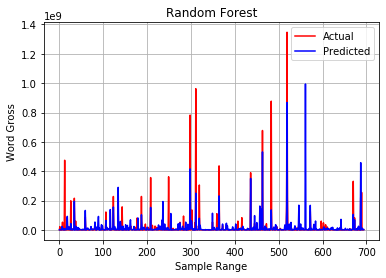

In [12]:
random_forest_model = RandomForestRegressor()
rsquare, mae, mse = run_model_with_plot("Random Forest", random_forest_model, X_train, X_test, y_train, y_test)

In [13]:
run_model_with_k_fold("Random Forest", random_forest_model, tokenized_data, atemp[predict_col], 4)

Random Forest with k fold
rsquare test mean:  0.4725096365233364
mae test mean:  16005678.237771643
mse test mean 3722619234278458.5


(0.4725096365233364, 16005678.237771643, 3722619234278458.5)

## 10, 20, 30, 40, 50, 100 comparison. cagegory = 'genre, actors'

In [14]:
category = "A" #actor only
for ch in [10,20,30,40,50,100]:
    set_max_run_model_and_append_to_result("Random_Forest", category, RandomForestRegressor(), ch, atemp, b_print=False)

C:\Users\Ling\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Ling\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Ling\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Ling\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Ling\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: Future

In [17]:
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)


In [18]:
category = "G" #genres only
for ch in [10,20,30,40,50,100]:
    set_max_run_model_and_append_to_result("Random_Forest", category, RandomForestRegressor(), ch, atemp, b_print=False)

In [19]:
category = "C" #country only
for ch in [10,20,30,40,50,100]:
    set_max_run_model_and_append_to_result("Random_Forest", category, RandomForestRegressor(), ch, atemp, b_print=False)

In [20]:
category = "D" #directors only
for ch in [10,20,30,40,50,100]:
    set_max_run_model_and_append_to_result("Random_Forest", category, RandomForestRegressor(), ch, atemp, b_print=False)

In [21]:
category = "W" #writers only
for ch in [10,20,30,40,50,100]:
    set_max_run_model_and_append_to_result("Random_Forest", category, RandomForestRegressor(), ch, atemp, b_print=False)

In [22]:
category = "WDCG" #
for ch in [10,20,30,40,50,100]:
    set_max_run_model_and_append_to_result("Random_Forest", category, RandomForestRegressor(), ch, atemp, b_print=False)

In [23]:
category = "WDC" #actor only
for ch in [10,20,30,40,50,100]:
    set_max_run_model_and_append_to_result("Random_Forest", category, RandomForestRegressor(), ch, atemp, b_print=False)

In [24]:
model_result

,model_names,categories,kfold,max_features,rsquare,mse,mae
0,Random_Forest,a,False,10,0.417037,4.820353e+15,1.727702e+07
1,Random_Forest,a,True,10,0.446040,3.901352e+15,1.679695e+07
2,Random_Forest,a,False,20,0.418956,4.804487e+15,1.711861e+07
3,Random_Forest,a,True,20,0.443982,3.905763e+15,1.668133e+07
4,Random_Forest,a,False,30,0.411386,4.867083e+15,1.697155e+07
5,Random_Forest,a,True,30,0.440579,3.934851e+15,1.665734e+07
6,Random_Forest,a,False,40,0.492737,4.194411e+15,1.594370e+07
7,Random_Forest,a,True,40,0.440387,3.955936e+15,1.650412e+07
8,Random_Forest,a,False,50,0.473957,4.349699e+15,1.622503e+07
9,Random_Forest,a,True,50,0.447879,3.923211e+15,1.637002e+07


In [26]:
kfold_random_forest= model_result[model_result['kfold']==True]

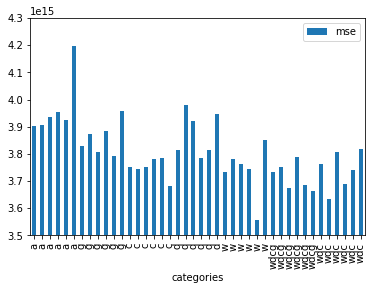

In [42]:
kfold_random_forest[['categories', 'mse']].plot(x='categories', y='mse',kind='bar',ylim=(3.5e15,4.3e15))

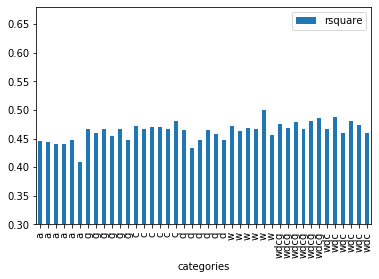

In [43]:
kfold_random_forest[['categories', 'rsquare']].plot(x='categories', y='rsquare',kind='bar',ylim=(0.3,0.68))

# K Nearest Neighbors

## set max_feature for each category = 30, k = 4

In [46]:
from sklearn.neighbors import KNeighborsRegressor

Now category has:  ['directors']
True
for each category except genre, the max features are:  30
data shape:  (23474, 37)
------model name:  K_Nearest_neighbors_ball_tree_5 ------
R suqare:  -0.10583880084441488
mean absolute error:  27076779.8228754
mean square error:  9143867597235208.0


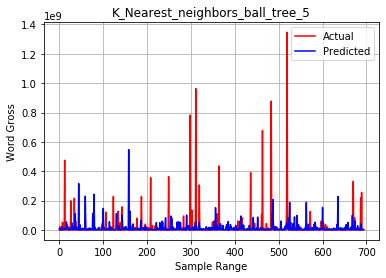

K_Nearest_neighbors_ball_tree_5 with k fold
rsquare test mean:  -0.13495922457253756
mae test mean:  26046648.902262587
mse test mean 8092016281521779.0


In [49]:
category = "D" #directors only
set_max_run_model_and_append_to_result( "K_Nearest_neighbors_ball_tree_5", category,
                                           KNeighborsRegressor(n_neighbors = 5, algorithm='ball_tree'),
                                           30, atemp)

Now category has:  ['genres', 'Country', 'directors', 'writers']
True
for each category except genre, the max features are:  30
data shape:  (23474, 119)
------model name:  K_Nearest_neighbors_ball_tree_5 ------
R suqare:  -0.0916023191331885
mean absolute error:  27221640.90189563
mean square error:  9026150165256414.0


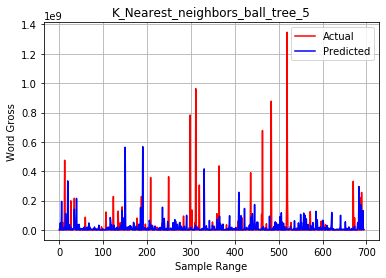

K_Nearest_neighbors_ball_tree_5 with k fold
rsquare test mean:  -0.18941628309369335
mae test mean:  27399666.06283854
mse test mean 8462164815518472.0


In [50]:
category = "WDCG" #directors only
set_max_run_model_and_append_to_result( "K_Nearest_neighbors_ball_tree_5", category,
                                           KNeighborsRegressor(n_neighbors = 5, algorithm='ball_tree'),
                                           30, atemp)

Now category has:  ['genres', 'Country', 'directors', 'writers']
True
for each category except genre, the max features are:  30
data shape:  (23474, 119)
------model name:  K_Nearest_neighbors_KD_tree_5 ------
R suqare:  -0.0916023191331885
mean absolute error:  27221640.90189563
mean square error:  9026150165256414.0


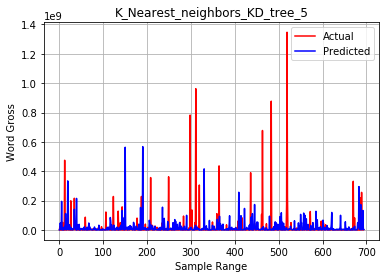

K_Nearest_neighbors_KD_tree_5 with k fold
rsquare test mean:  -0.18941628309369335
mae test mean:  27399666.06283854
mse test mean 8462164815518472.0


In [52]:
category = "WDCG" #directors only
set_max_run_model_and_append_to_result( "K_Nearest_neighbors_KD_tree_5", category,
                                           KNeighborsRegressor(n_neighbors = 5, algorithm='kd_tree'),
                                           30, atemp)

Now category has:  ['genres', 'Country', 'directors', 'writers']
True
for each category except genre, the max features are:  30
data shape:  (23474, 119)
------model name:  K_Nearest_neighbors_KD_tree_5 ------
R suqare:  -0.02653973562226808
mean absolute error:  27160479.80241747
mean square error:  8488166104013822.0


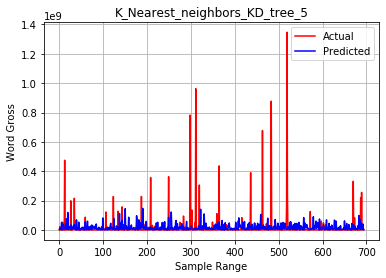

K_Nearest_neighbors_KD_tree_5 with k fold
rsquare test mean:  -0.04352203737917437
mae test mean:  26395796.4370367
mse test mean 7478668007662761.0


In [53]:
category = "WDCG" #directors only
set_max_run_model_and_append_to_result( "K_Nearest_neighbors_KD_tree_20", category,
                                           KNeighborsRegressor(n_neighbors = 20, algorithm='kd_tree'),
                                           30, atemp)

In [ ]:
model_result

# Decision Tree

In [54]:
from sklearn import tree

Now category has:  ['genres', 'Country', 'directors', 'writers']
True
for each category except genre, the max features are:  30
data shape:  (23474, 119)
------model name:  Decision_tree ------
R suqare:  -0.04851567713751548
mean absolute error:  20452154.77082002
mean square error:  8669878935383606.0


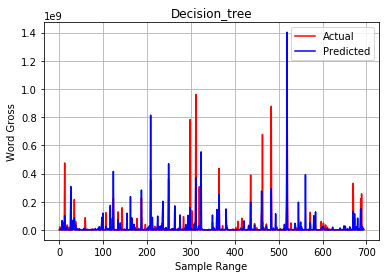

Decision_tree with k fold
rsquare test mean:  0.10014194323040937
mae test mean:  18350347.30968612
mse test mean 6308654825529322.0


In [55]:
category = "WDCG" #directors only
set_max_run_model_and_append_to_result( "Decision_tree", category,
                                           tree.DecisionTreeRegressor(),
                                           30, atemp)

Now category has:  ['genres', 'Country', 'directors', 'writers', 'actors']
True
for each category except genre, the max features are:  30
data shape:  (23474, 148)
------model name:  Decision_tree ------
R suqare:  0.18295017469147656
mean absolute error:  17994732.431735888
mean square error:  6755953414964701.0


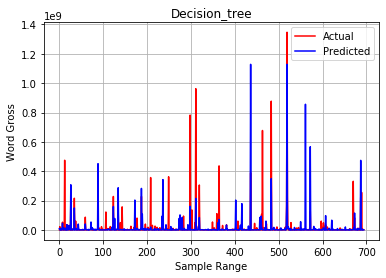

Decision_tree with k fold
rsquare test mean:  0.23112879623922272
mae test mean:  17445653.894550227
mse test mean 5364942253936005.0


In [56]:
category = "WDCGA" #directors only
set_max_run_model_and_append_to_result( "Decision_tree", category,
                                           tree.DecisionTreeRegressor(),
                                           30, atemp)

# AdaBoostRegression, GradientBoostingRegressor

In [58]:
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor

Now category has:  ['genres', 'Country', 'directors', 'writers', 'actors']
True
for each category except genre, the max features are:  30
data shape:  (23474, 148)
------model name:  AdaBoost ------
R suqare:  -3.767887355690175
mean absolute error:  190540201.6277548
mean square error:  3.942430909972807e+16


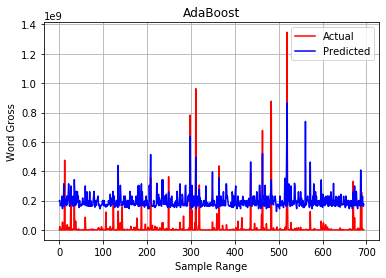

AdaBoost with k fold
rsquare test mean:  -6.3909415753877425
mae test mean:  218236431.49815586
mse test mean 5.060128733903125e+16


In [59]:
category = "WDCGA" #directors only
set_max_run_model_and_append_to_result( "AdaBoost", category,
                                           AdaBoostRegressor(),
                                           30, atemp)

Now category has:  ['actors']
True
for each category except genre, the max features are:  30
data shape:  (23474, 37)
------model name:  Gradient_Boosting ------
R suqare:  0.41562014873901443
mean absolute error:  16870892.566301495
mean square error:  4832071349225749.0


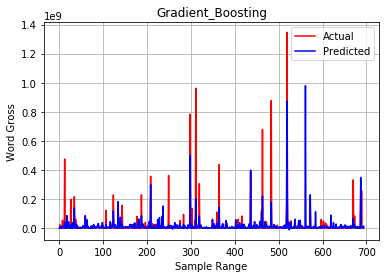

Gradient_Boosting with k fold
rsquare test mean:  0.4619329292580515
mae test mean:  16488027.476523666
mse test mean 3801615975280646.5


In [60]:
category = "A" #directors only
set_max_run_model_and_append_to_result( "Gradient_Boosting", category,
                                           GradientBoostingRegressor(),
                                           30, atemp)

In [61]:
category = "G" 
set_max_run_model_and_append_to_result( "Gradient_Boosting", category,
                                           GradientBoostingRegressor(),
                                           30, atemp, b_print=False)
category = "W" 
set_max_run_model_and_append_to_result( "Gradient_Boosting", category,
                                           GradientBoostingRegressor(),
                                           30, atemp, b_print=False)
category = "C" 
set_max_run_model_and_append_to_result( "Gradient_Boosting", category,
                                           GradientBoostingRegressor(),
                                           30, atemp, b_print=False)
category = "D" 
set_max_run_model_and_append_to_result( "Gradient_Boosting", category,
                                           GradientBoostingRegressor(),
                                           30, atemp, b_print=False)
category = "WDCG" 
set_max_run_model_and_append_to_result( "Gradient_Boosting", category,
                                           GradientBoostingRegressor(),
                                           30, atemp, b_print=False)
category = "WDC" 
set_max_run_model_and_append_to_result( "Gradient_Boosting", category,
                                           GradientBoostingRegressor(),
                                           30, atemp, b_print=False)

In [63]:
category = "WDCGA" 
set_max_run_model_and_append_to_result( "Gradient_Boosting", category,
                                           GradientBoostingRegressor(),
                                           30, atemp, b_print=False)

In [64]:
model_result

,model_names,categories,kfold,max_features,rsquare,mse,mae
0,Random_Forest,a,False,10,0.417037,4.820353e+15,1.727702e+07
1,Random_Forest,a,True,10,0.446040,3.901352e+15,1.679695e+07
2,Random_Forest,a,False,20,0.418956,4.804487e+15,1.711861e+07
3,Random_Forest,a,True,20,0.443982,3.905763e+15,1.668133e+07
4,Random_Forest,a,False,30,0.411386,4.867083e+15,1.697155e+07
5,Random_Forest,a,True,30,0.440579,3.934851e+15,1.665734e+07
6,Random_Forest,a,False,40,0.492737,4.194411e+15,1.594370e+07
7,Random_Forest,a,True,40,0.440387,3.955936e+15,1.650412e+07
8,Random_Forest,a,False,50,0.473957,4.349699e+15,1.622503e+07
9,Random_Forest,a,True,50,0.447879,3.923211e+15,1.637002e+07


## Multi-layer Perceptron regressor

In [65]:
from sklearn.neural_network import MLPRegressor

In [76]:
regressor = MLPRegressor(hidden_layer_sizes = (40,20), activation = 'relu', solver = 'adam', learning_rate = 'adaptive')

Now category has:  ['genres', 'directors', 'writers']
True
for each category except genre, the max features are:  30
data shape:  (23474, 90)
------model name:  MLP ------
R suqare:  -0.006219333247762915
mean absolute error:  24734334.154902704
mean square error:  8320142456540846.0


C:\Users\Ling\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


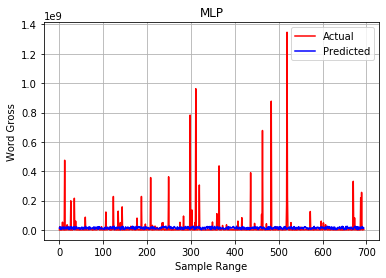

C:\Users\Ling\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ling\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ling\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLP with k fold
rsquare test mean:  -0.004154347383724666
mae test mean:  24075886.69455929
mse test mean 7221979791528967.0


C:\Users\Ling\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [77]:
category = "WDG" 
set_max_run_model_and_append_to_result( "MLP", category,
                                           regressor,
                                           30, atemp)
